## Spatial receptive fields in the ventral stream##

I want to get a clear image in my mind of the spatial sampling of an image at each stage of the ventral stream, this comes down to the shape of receptive fields and the number of receptive fields, as a function of eccentricity and angle in the visual field. 

### Visual Space###

Degrees visual angle is defined for a given extent of visual space as the angle that extent makes with respect to the focal point on the lens of the eye. 

$$V = 2\arctan(\frac{S}{2D})$$

where S is the extent of the stimulus, D is the distance to the stimulus (in the same units as S), and V is the degree visual angle of that stimulus. Given V we can learn the extent of that stimulus on the retina:

$$R = \nu \tan(V)$$

where $\nu \approx 17 mm$

and the total degrees visual angle is roughly $160$

### Cones###

A major prior on the visual system is the spatial sampling in the retina. Higher visual frequencies are more discriminable in the fovea then in the periphery. But by how much?

Here we will use data from : The Distribution of Cones in the Primate Retina. 1990. Digitized from Figure 2. https://www.ncbi.nlm.nih.gov/books/NBK235556/figure/mmm00055/?report=objectonly

Looking at the temporal horizontal meridian. I believe this is between the fovea and the ear.

TypeError: a float is required

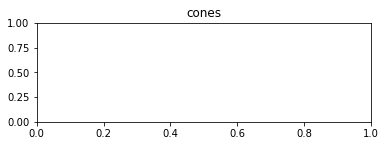

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import csv
with open("cones_mm2_dg.csv") as f:
    reader = csv.reader(f)
    next(reader) # skip header
    data = np.array([[np.double(r[0]), np.double(r[1])] for r in reader])
cones = data

lcx = (np.log10(cones[:,0]));
lcy = (np.log10(cones[:,1]))[:, np.newaxis];
x = np.linspace(0.1, 60, 100)

plt.subplot(211)
plt.title('cones')

A = np.vstack([lcx, np.ones(len(lcx))]).T;
m, c = np.linalg.lstsq(A , lcy, rcond=None)[0];
plt.loglog(x, (10**c)*(x**m), color='b');
plt.scatter(cones[:,0], cones[:,1]);

print('Exponent= ' + str(np.round(m,2)))
print('Multiplier= ' + str(np.round(c,2)))
plt.xlabel('vis deg.');plt.ylabel('cone/mm^2');
plt.legend(['Exp Fit', 'Data']);

In [ ]:
plt.plot(cones[:,0], 10**(m*lcx + c), color='r')

x = np.linspace(0.1, 60, 100)
plt.plot(x, (10**c)*(x**m), color='b')

plt.scatter(cones[:,0], cones[:,1])
plt.xlabel('vis deg.');plt.ylabel('cone/mm^2');
plt.legend(['Exp fit', 'Data'])

In [ ]:
plt.plot(cones[:,0], np.sqrt(10**(m*lcx + c)), color='r')
plt.scatter(cones[:,0], np.sqrt(cones[:,1]))
plt.xlabel('vis deg.');plt.ylabel('cone/mm');
plt.legend(['Exp fit', 'Data'])

So we now have an approximate formula for number of cones/mm^2 as a function of eccentricity. Can we get this to be a function of visual angle? 

Well if we take the square root of cones/mm^2 we get how many cones on the side of a unit square containing all those cones. 

Which is essentially if we draw a line from the fovea radiating outward on a given section of the line a mm long how many cones do we expect.  

Now to convert from mm on the retina to degrees visual angle we ask how many mm/v. deg are there?
Since 
$$R = \nu \tan(V)$$
then for 1 mm there are:
$$V = \arctan(1/\nu)$$

In [ ]:
nu=17
x = np.linspace(0.01, 60, 100)
old_y = (10**c)*(x**m)
new_y = np.sqrt(old_y);
degpmm = np.rad2deg(np.arctan(1/nu))
new_y = new_y/degpmm;

plt.plot(x, new_y, color='r');
plt.ylabel('Cones/deg');
plt.xlabel('Eccentricity deg.');

For scale 1 degree is about the size of the nail of your index finger with your arm outstretched. So on your fingernail are a 100X100 grid of cones with a nyquist frequency of 1/50 cycles/deg vis angle.

In V4 experiments typically the stimuli is scaled to the receptive field, where receptive fields are in turn a function of eccentricity, stimuli being place from 0 to 6 deg from RF center.

$$RF_{V4} =1^\circ + 0.625 * Ecc.$$

So at 6 deg the RF is ~5 degrees visual angle and the shape is made 3/4 of that size 3.75 degrees. Which means a sampling of 112 cones on each side. Close to what we would expect for looking at a 1 deg item at the center of vision.

In [ ]:
plt.plot(x, new_y**-1, color='r');
plt.ylabel('Deg/Cone');
plt.xlabel('Eccentricity deg.');

Here we just flip the ratio to Deg/Cones to tell us the spacing between cones in degrees. This will be helpful when discretizing the cones.

### Discretized cone sampling###

So given an arbitrary image and window in visual space we want to place 'cones' samples across it such that it matches the density and transition in density we would expect for our estimates of cone density above. We will proceed with this as follows. First we will consider rings of equal eccentricity around the fovea where we have an estimate for a given length of visual degrees how many photoreceptors to expect. To determine the distance between these rings we will place one at the edge of our stimuli closest to the fovea and the distance to the next ring will be the deg/cone at the current rings eccentricity.

We will also need to resample the input image at arbitrary points so we can grab samples wherever the cones end up.

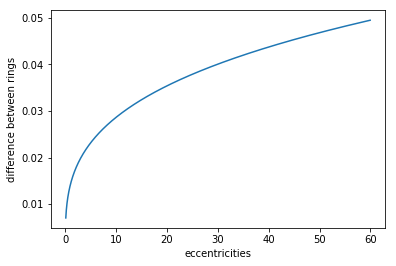

In [2]:
#so we will start with a circular portion of visual space in visual degrees. 
#we want a function which takes the radius and its center in visual degrees. 
#then it gives the location of a set of cone locations in visual degrees. 

#to do this we will need a function which takes a starting and ending eccentricity.
#then gives the set of eccentricities in between. these are for the rings.
def cone_per_deg(ecc, e=-.61, m=4.75, nu=17):
    y = (np.sqrt((10**m)*(ecc**e)))
    y = y/np.rad2deg(np.arctan(1/nu));
    return y

def ring_ecc_spacing(ecc_start, ecc_end,):
    ecc_cur = ecc_start
    ecc_list = []
    while ecc_cur < ecc_end:
        ecc_list.append(ecc_cur)
        ecc_cur = ecc_cur + cone_per_deg(ecc_cur)**-1#get degree per cone for distance to next ring
    return np.array(ecc_list)

ecc_list = ring_ecc_spacing(0.1, 60)

plt.plot(ecc_list[1:], np.diff(ecc_list));
plt.xlabel('eccentricities');
plt.ylabel('difference between rings');

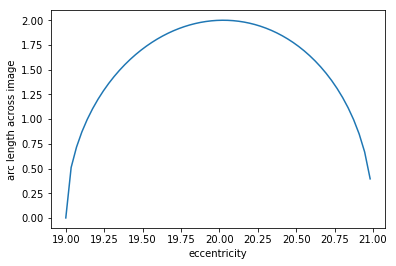

In [3]:
#then to place cones along those rings we will need a function that given an eccentricity and an arc length.
#will return the number of cones along that arc length.
im_ecc = 20
im_radius = 1
im_angle = np.deg2rad(315);

ecc_list = ring_ecc_spacing(im_ecc-im_radius, im_ecc+im_radius)

#to do this we need a function that given an eccentricity, image center,
#and radius returns the angles of the arc with respect to fovea
def get_angle_across_circim(im_ecc, im_radius, ring_ecc_from_fov):
    d_theta  = np.arccos((ring_ecc_from_fov**2 + im_ecc**2 - im_radius**2)/(2*ring_ecc_from_fov*im_ecc))
    return 2*d_theta

def arc_length(angle, radius):
    #in radians
    return radius*angle

def n_cones_per_arclength_given_ecc(arclength, ecc):
    cpd = cone_per_deg(ecc)
    return cpd*arclength

d_theta = []
for ring_ecc_from_fov in ecc_list:
    d_theta.append(get_angle_across_circim(im_ecc, im_radius, ring_ecc_from_fov))
d_theta_list = np.array(d_theta)    

arc_length_list = d_theta*ecc_list
n_cones = []
for arclength, ecc in zip(arc_length_list, ecc_list):
    n_cones.append(n_cones_per_arclength_given_ecc(arclength, ecc))
n_cones = np.array(n_cones)


plt.figure()
plt.plot(ecc_list, arc_length_list)
plt.xlabel('eccentricity')
plt.ylabel('arc length across image')

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


57

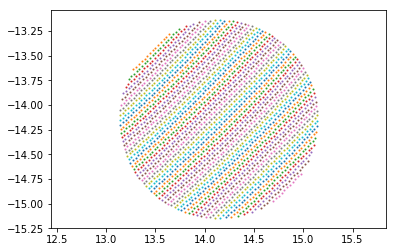

In [4]:
# so we have the eccentricities of each ring and the number of cones on each ring.
# now we need to get all of their locations.
# we get angle range linearly space n cones along it, and associate the ecc with it

angles = []
for ecc, d_theta, n_cone in zip(ecc_list, d_theta_list, n_cones):
    angles.append(np.linspace(im_angle - d_theta/2., im_angle + d_theta/2., n_cone))
def pol2cart(r, theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return (x, y)

for r, thetas in zip(ecc_list, angles):
    x_list = []
    y_list = []
    for theta in thetas:
        (x,y) = pol2cart(r, theta)
        x_list.append(x)
        y_list.append(y)
    plt.scatter(x_list, y_list, s=1)

plt.axis('equal');

len(ecc_list)
#we will then have another function which takes a square image scaled to that circle in visual space
#then resamples the image at those points. returning a list of locations and rgb values.

#to display it we will plot points in visual space with colors corresponding to those samples.
# seems way to dense?

### The retino-cortico transform###

The cones and assosciated RGC are exponentially spaced out from the fovea, whereas V1 is tightly packed. The question then is how a point in retinal space maps onto points in the cortex.
Define a point in visual space radially with $\epsilon$ as eccentricity from fovea in degrees visual angle, $\theta$ as orientation with respect to the center of the fovea.

Define a point in centimeters in V1 with $X \in [0,3]$ moving lateral away from the corpus callosum toward the fovea, and $Y \in [-2,2]$ moving ventral and posterior from fovea with $Y=0$ corresponding to the calcarine fissure and Y>0 corresponding to the bottom of visual space.
We want to know the relation between $(X, Y)$ on V1 and ($\epsilon, \theta$) in the retina. Or determine the function $X(\epsilon, \theta)$ and $Y(\epsilon, \theta)$

This is where the cortical magnifcation factor comes into play $M(\epsilon) = \frac{dX}{d \epsilon}$ which intuitively is just the proportion of change in X cm's that we get for a small displacement in eccentricity in any angular direction.

a reasonable estimate is $M(\epsilon) = \frac{dX}{d \epsilon}=\frac{1.2 cm}{1+\epsilon}$

If we integrate this we can get the actual X value:

$X = 1.2 \ln{(1+\epsilon/\epsilon_0)}$



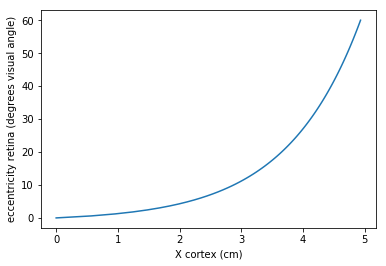

In [5]:
lam = 1.2
eps = np.linspace(0, 60,100)
x = lam*np.log(1+eps)
plt.plot(x, eps);
plt.xlabel('X cortex (cm)');
plt.ylabel('eccentricity retina (degrees visual angle)');

Now we want to know given an $\epsilon$ what is the arc length between two points with some azimuthal difference $\Delta \theta \rightarrow 0$:

$\frac{dY}{d\theta} = - \frac{M(\epsilon)\epsilon \pi}{180^\circ}$

here $\frac{pi}{180^\circ}$ normalizes to radians, $\epsilon$ takes into account increasing arc length with eccentricity and $M(\epsilon)$ takes into account proportional distance changes on cortex. Taking the integral to find $Y$:

$Y=-\frac{1.2 \epsilon \theta \pi}{(1+\epsilon)180^\circ}$

Now lets try applying this to an image:
Lets say we have a Han Solo image centered at 10 degrees eccentricity subtending 12 degrees (a V4 receptive field)

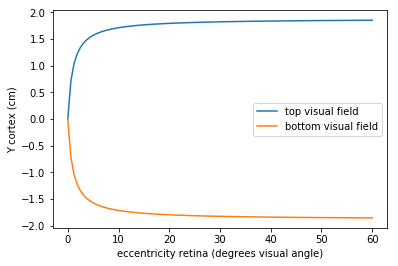

In [6]:
theta = 90 
y = (lam*eps*theta*np.pi)/((1+eps)*180)
plt.plot(eps, y);
plt.plot(eps, -y);
plt.ylabel('Y cortex (cm)');
plt.xlabel('eccentricity retina (degrees visual angle)');
plt.legend(['top visual field', 'bottom visual field'])

In [11]:
def rc_trans(eps, theta):
    y = (lam*eps*theta*np.pi)/((1+eps)*180)
    x = lam*np.log(1+eps)
    return x, y
    


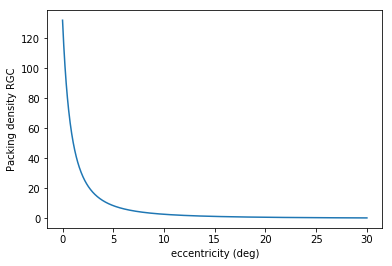

In [12]:
w_0 = 0.087
eps = 0.051
r = np.linspace(0, 30, 1000)

rho = (w_0 + eps*r)**(-2)

plt.plot(r, rho);
plt.xlabel('eccentricity (deg)');
plt.ylabel('Packing density RGC');

Retinal gangnlion packing density ($\rho_R$ cells per unit retinal area):
$$\rho_R = (w_0 + \epsilon r_R)^{-2}$$

$w_0 = 0.087$

$\epsilon = 0.051 $

$r_R = $ radius from fovea degrees visual angle  

### Cortical receptive fields###

To a first approximation ($r=$ RF width and $e = $ eccentricity both in visual degrees)
V1

$r = 1 + 0.16e$

V2

$r = 2 + 0.4e$

V3 

Essen 1987 says 1.26 + 0.18e but they say in the same study V3 was larger than V2? 
Lets just put it between V2 and V4

$r = 2.5 + 0.575e$

V4

$r =  3 + 0.75e$

So to a first approximation we see a slowing rate of increase in RF size. 

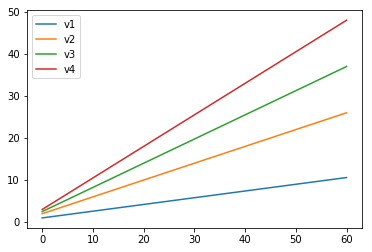

In [9]:
rfs = [0.16, 0.4, .575, .75]
offsets = [1, 2, 2.5, 3]

ecc = np.linspace(0,60,100)
for scale, shift in zip(rfs, offsets):
    plt.plot(ecc, ecc*scale+shift)

plt.legend(['v1', 'v2', 'v3', 'v4'])

In [10]:
rfs = np.array(rfs)[:, np.newaxis].T
ratios = rfs/rfs.T
print(np.round(ratios,2))

[[ 1.    2.5   3.59  4.69]
 [ 0.4   1.    1.44  1.88]
 [ 0.28  0.7   1.    1.3 ]
 [ 0.21  0.53  0.77  1.  ]]


We can conclude from this that we can fit roughly 5 V1 receptive fields (given eccentricity at the center of the rf) end to end across a V4 receptive field, 3.6 into a V3, 2.5 into a V2. But beyond that there cannot be two RFs non-overlapping from V2 onward feeding into something upstream, so heavy overlap is the norm. So if I put in two well seperated stimuli in a single RF they might interact with two relatively independent V1 units but they will likely be under the umbrella of single feedforward input RF's thus will most likely interact at earlier stages of the hiearchy.

We can caveat this with the fact that RF's are large and so are extending into more foveal regions where RF's will be smaller. 